# CNN for task performance comparison

#### Unzip files

In [0]:
# unzip files
import zipfile

UNZIP_NAME = 'mnist.zip'

zip_ref = zipfile.ZipFile(UNZIP_NAME, 'r')
zip_ref.extractall('./')
zip_ref.close()

## Get data

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#### Import data

In [0]:
#DATA_PATH = '/Users/anthony/Documents/Comp551_Projects/CapNET/data/mnistData.npz'
DATA_PATH = 'fashion_mnist_Data.npz'

npzfile = np.load(DATA_PATH)
npzfile.files

['X_train', 'y_train', 'X_test', 'y_test']

#### Unpack - take subset? 

In [0]:
TAKE_SUBSET = True
SUBSET_SIZE = 6000

# Unpack the training and testing datasets
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

# Take subset
if TAKE_SUBSET:
    X_train = X_train[0:SUBSET_SIZE]
    y_train = y_train[0:SUBSET_SIZE]
    
# Expand the dimension of images to signal greyscale
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(6000, 28, 28, 1)
(6000, 10)
(10000, 28, 28, 1)
(10000, 10)


### Check Normalization

In [0]:
SCALE = True

print("Original Feature range: [%f - %f]" % (np.min(X_train),np.max(X_train)))

if SCALE:
  X_train = X_train / np.max(X_train)
  X_test = X_test / np.max(X_test)
  
  print("Scale Feature Ranges:")
  print("[%f - %f]" % (np.min(X_train),np.max(X_train)))
  print("[%f - %f]" % (np.min(X_test),np.max(X_test)))


Original Feature range: [0.000000 - 255.000000]
Scale Feature Ranges:
[0.000000 - 1.000000]
[0.000000 - 1.000000]


## Set up convolutional net

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D
from keras.layers import BatchNormalization
import keras.layers

### Define model(s)

In [0]:
def basic_CNN():
    # Input layer
    x = Input(shape=(28,28,1))
    
    # First convolution
    conv1 = Conv2D(filters=256, kernel_size=9, strides=1,\
                          padding='valid', activation='relu')(x)
    
    # Second convolution (32 capsules * 8 dimensions: 256 individual filters equivalency )
    conv2 = Conv2D(filters=256, kernel_size=9, strides=2,\
                          padding='valid', activation='relu')(conv1)
    
    # Max pooling (instead of dynamic routing)
    pool = MaxPooling2D(pool_size=2, strides=1)(conv2)
    
    # Third convolution (10 capsules * 16 dimension: 160 individual filter equivapency)
    conv3 = Conv2D(filters=160, kernel_size=5, strides=1,\
                          padding='valid', activation='relu')(pool)
    
    # Flatten
    flat = Flatten()(conv3)
    
    # Output layer
    fc = Dense(10, activation='softmax')(flat)    
    
    # Compile model
    model = Model(x, fc)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
  
def reguNormed_CNN():
    # Input layer
    x = Input(shape=(28,28,1))
    
    # First convolution
    conv1 = Conv2D(filters=256, kernel_size=9, strides=1,\
                          padding='valid', activation='relu')(x)
    drop1 = keras.layers.Dropout(0.3)(conv1)
        
    # Second convolution (32 capsules * 8 dimensions: 256 individual filters equivalency )
    conv2 = Conv2D(filters=256, kernel_size=9, strides=2,\
                          padding='valid', activation='relu')(drop1)
    
    # Max pooling (instead of dynamic routing)
    pool = MaxPooling2D(pool_size=2, strides=1)(conv2)
    drop2 = keras.layers.Dropout(0.3)(pool)
        
    # Third convolution (10 capsules * 16 dimension: 160 individual filter equivapency)
    conv3 = Conv2D(filters=160, kernel_size=5, strides=1,\
                          padding='valid', activation='relu')(drop2)
    
 
    # Flatten and batch normalize
    flat = Flatten()(conv3)
    norm = BatchNormalization()(flat)
    
    # Output layer
    out = Dense(10, activation='softmax')(norm)
    
    # Compile model
    model = Model(x, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
    

In [0]:
#model = basic_CNN()
model = basic_CNN()
model.summary()

## TODO: compare the number of parameters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 20, 20, 256)       20992     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 6, 256)         5308672   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 1, 1, 160)         1024160   
_________________________________________________________________
flatten_12 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1610      
Total para

### Train model

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=60,
                    shuffle=True,
                    validation_data=(X_test, y_test)
                   )

Train on 6000 samples, validate on 10000 samples
Epoch 1/20
6000/6000 [==============================] - 11s 2ms/step - loss: 0.8855 - acc: 0.6728 - val_loss: 0.6711 - val_acc: 0.7536
Epoch 2/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.5546 - acc: 0.8007 - val_loss: 0.5847 - val_acc: 0.7887
Epoch 3/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.4704 - acc: 0.8288 - val_loss: 0.4797 - val_acc: 0.8245
Epoch 4/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.4051 - acc: 0.8518 - val_loss: 0.5546 - val_acc: 0.8006
Epoch 5/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.3637 - acc: 0.8663 - val_loss: 0.4766 - val_acc: 0.8279
Epoch 6/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.3308 - acc: 0.8748 - val_loss: 0.4462 - val_acc: 0.8458
Epoch 7/20
6000/6000 [==============================] - 10s 2ms/step - loss: 0.2880 - acc: 0.8970 - val_loss: 0.4653 - val_acc: 0.8489
Epoch 

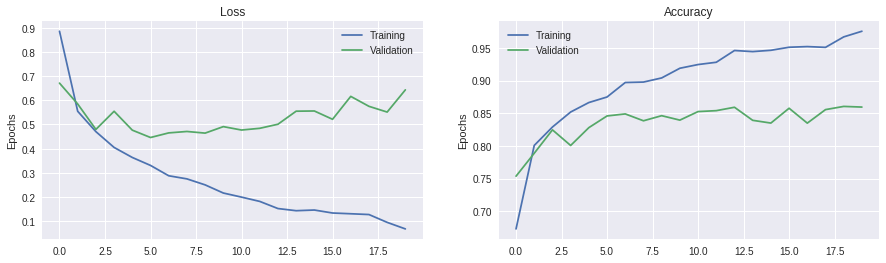

In [0]:
# Plot history
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Epochs')
plt.legend(['Training','Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Epochs')
plt.legend(['Training','Validation'])

plt.show()

In [0]:
# Save training history
import pickle

SAVE_HISTORY = True
MODEL_NAME = 'fashionMnist_CNN_simpleFF_20Epochs'


if SAVE_HISTORY:
  pickle.dump( history, open('%s_history.pickle'%MODEL_NAME, 'wb') )

